In [209]:
import pandas as pd
import json as js
import requests
from io import StringIO
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
import numpy as np

This section is what I tried in order to get the Billboard tables scraped. Because it's a complicated HTML structure (at least compared to Wikipedia) I had some trouble targeting it. I was getting errors until I spent an hour watching Beautifulsoup tutorials to try and target it, but decided it's worth it to explore other options first. If I end up needing this data I could give it another shot.

My (rough) idea now is to look at the number of times the top tours (maybe top five or so?) visited different cities and find which ones are the most visited. I think I would limit my analysis to cities in the US for the sake of brevity and also to ensure I have the right financial data. Something to consider would be the populations of the states as well, and how that could affect the number of times a city is visited. 

I'd also like to look into some kind of way to map the region of a city/venue. In my experience, artists will have two shows in California (North and South) and then a show in Chicago and Philidelphia and nothing in-between. Because of the population density, Chicago is like the bastion for concerts in the Midwest. It would be interesting to see region (and population) taken into account too to see how many are in each region.

In [135]:
url_wiki = 'https://www.billboard.com/2023-year-end-boxscore-charts/#pmc-protected-embed-2'

In [136]:
response1 = requests.get(url_wiki)
response1.status_code

200

In [137]:
soup = BeautifulSoup(response1.text, "html.parser")
the_table = soup.find('table',{'class':"medium datawrapper-OPu6B-sqmikr svelte-1smti70 striped compact resortable"})
print(the_table)

None


In [138]:
eras_tour = 'https://en.wikipedia.org/wiki/The_Eras_Tour#:~:text=Long%20Story%20Short%22-,Tour%20dates,-List%20of%202023'

In [139]:
response2 = requests.get(eras_tour)
response2.status_code

200

In [140]:
eras_tour_list = pd.read_html(StringIO(response2.text))
type(eras_tour_list)

list

I was a little surprised by how many things on Wikipedia pages are coded as tabled so it was mostly trial and error in terms of the index number to get the one I needed.

It was mentioned that the Wikipedia articles all cite data for their tables, but from my poking around it looks like they are once again citing Pollstar (paid) or an already put-together report, the same problems I've been running into. At least it's already concantenated for me though!

In [141]:
eras_2023 = eras_tour_list[5]
eras_2024 = eras_tour_list[6]

eras_2023.head()

,Date (2023),City,Country,Venue,Opening acts,Attendance,Revenue
0,March 17,Glendale,United States,State Farm Stadium,Paramore Gayle,—,—
1,March 18,Glendale,United States,State Farm Stadium,Paramore Gayle,—,—
2,March 24,Paradise[i],United States,Allegiant Stadium,Beabadoobee Gayle,—,—
3,March 25,Paradise[i],United States,Allegiant Stadium,Beabadoobee Gayle,—,—
4,March 31,Arlington,United States,AT&T Stadium,Muna Gayle,—,—


In [142]:
eras_2023['Date (2023)'] = eras_2023['Date (2023)'].astype(str) + ' 2023'
eras_2024['Date (2024)'] = eras_2024['Date (2024)'].astype(str) + ' 2024'

eras_2023.rename(columns={'Date (2023)': 'Date'}, inplace=True)
eras_2024.rename(columns={'Date (2024)': 'Date'}, inplace=True)

In [143]:
eras_tour_merged = pd.concat([eras_2023, eras_2024], axis = 0)
# eras_tour_merged.head()

Something I noticed with the Eras tour here as well is that very few dates are in the US (comparatively). Just skimming the Wikipedia article it looked a lot more global than it actually was, but nearly half of the dates were in the US. Glad I checked the numbers first before worrying about the results.

In [144]:
count_us_eras = (eras_tour_merged['Country'] == 'United States').sum()
print("Times in US:", count_us_eras)

count_global_eras = eras_tour_merged['Country'].ne('United States').sum()
print("Times Abroad:", count_global_eras)

Times in US: 62
Times Abroad: 88


In [145]:
ej = 'https://en.wikipedia.org/wiki/Farewell_Yellow_Brick_Road'

In [146]:
response3 = requests.get(ej)
response3.status_code

200

In [147]:
ej_list = pd.read_html(StringIO(response3.text))
type(ej_list)

list

In [148]:
ej_tours = ej_list[1]
ej_tours.head()

,Date,City,Country,Venue,Attendance,Revenue
,North America[32][33][34],North America[32][33][34],North America[32][33][34],North America[32][33][34],North America[32][33][34],North America[32][33][34]
0,8 September 2018,Allentown,United States,PPL Center,"8,983 / 8,983","$1,492,859"
1,11 September 2018,Philadelphia,United States,Wells Fargo Center,"29,531 / 29,531","$4,273,021"
2,12 September 2018,Philadelphia,United States,Wells Fargo Center,"29,531 / 29,531","$4,273,021"
3,15 September 2018,Buffalo,United States,KeyBank Center,"15,581 / 15,641","$2,033,001"
4,16 September 2018,University Park,United States,Bryce Jordan Center,"12,421 / 12,421","$1,662,468"


So I'd have to do some work to see if this table is busted (I don't think so, but the North America being included in the header is weirding me out. It's a subheader on the page, I just don't know if it would mess up any of the other data), but this seemed a lot more US-heavy looking at the page.

Something I'm concerned about is that this tour ended in the first half of 2023. Would I use the data from 2018-2022 if I was using financial data from 2023? Most of the 2023 dates are outside of the US, anyways. There's a chance I may not use financial data anyways and instead use regional and financial, but still something to think about.

In [149]:
count_us_ej = (ej_tours['Country'] == 'United States').sum()
print("Times in US:", count_us_ej)

count_global_ej = ej_tours['Country'].ne('United States').sum()
print("Times Abroad:", count_global_ej)

Times in US: North America[32][33][34]    163
dtype: int64
Times Abroad: North America[32][33][34]    176
dtype: int64


The Eras is #1 on the list of top-grossing tours and Elton John is #3. Since all of the other pages follow the same format I'll skip adding them for now, but as of writing I'm planning on doing the top 5 or maybe top 10 of these datasets.

In [150]:
df = pd.read_excel(r'C:\Users\gamec\Downloads\q3t3.xlsx')
# df.head()

Ughh, for readibility (I think) the excel sheet has blank cells on either side of the numbers. Unsure how to remove that logically but I'm sure there's an easy way.

So, now the idea is to get all of the dataframes in, add the artists/tour to each one, concantenate them into one big dataset(?), remove all the tour stops that aren't from the United States, group them by city, manually add the states for each city (scripted since there are duplicates), and then begin running some data from there. The verdict is out on whether I want to add the region too. We'll see :)

Maybe worth noting I haven't paid more than $20 for a concert ticket in 10 years. This is a foreign world to me lol

# ANALYSIS PLAN

First, I removed the opening acts from the eras tour chart since we won't need that information and I needed the number of columns to match the rest of the datasets. If you look back, I changed the code for the merged eras tour to not have the years in separate columns by appending the year to each cell and then renaming the column before merging into the merged table. The dates are in different format (Elton John is British), but as of now I'm not planning on using dates so I'm choosing not to worry.

In [151]:
eras_tour_merged.drop(['Opening acts'], axis=1, inplace=True)
eras_tour_merged.head()

,Date,City,Country,Venue,Attendance,Revenue
0,March 17 2023,Glendale,United States,State Farm Stadium,—,—
1,March 18 2023,Glendale,United States,State Farm Stadium,—,—
2,March 24 2023,Paradise[i],United States,Allegiant Stadium,—,—
3,March 25 2023,Paradise[i],United States,Allegiant Stadium,—,—
4,March 31 2023,Arlington,United States,AT&T Stadium,—,—


I tried a couple different scripts to do this but I kept removing the date and keeping the North America part, so I just did it manually

In [152]:
ej_tours.columns = ['Date', 'City', 'Country', 'Venue', 'Attendance', 'Revenue']
ej_tours.head()

,Date,City,Country,Venue,Attendance,Revenue
0,8 September 2018,Allentown,United States,PPL Center,"8,983 / 8,983","$1,492,859"
1,11 September 2018,Philadelphia,United States,Wells Fargo Center,"29,531 / 29,531","$4,273,021"
2,12 September 2018,Philadelphia,United States,Wells Fargo Center,"29,531 / 29,531","$4,273,021"
3,15 September 2018,Buffalo,United States,KeyBank Center,"15,581 / 15,641","$2,033,001"
4,16 September 2018,University Park,United States,Bryce Jordan Center,"12,421 / 12,421","$1,662,468"


Adding the artist so I can reference it later if needed

In [154]:
eras_tour_merged['Artist'] = "Taylor Swift"
ej_tours['Artist'] = "Elton John"

(Finally) merging the tables. 'inner' didn't work as a keyword so I used outer, as 'inner' was returning a blank table but I still need columns from both tables (please tell me if this is messing something up haha)

In [167]:
tours_merged = pd.merge(eras_tour_merged, ej_tours, how = 'outer')
tours_merged.head()

,Date,City,Country,Venue,Attendance,Revenue,Artist
0,1 April 2022[s],Indianapolis,United States,Gainbridge Fieldhouse,"14,789 / 14,789","$2,312,462",Elton John
1,1 December 2018,Atlanta,United States,State Farm Arena,"24,920 / 24,920","$3,310,272",Elton John
2,1 February 2019,Inglewood,United States,The Forum,"29,408 / 29,408","$3,973,836",Elton John
3,1 February 2022,Kansas City,United States,T-Mobile Center,"13,741 / 13,741","$2,368,483",Elton John
4,1 March 2019,Albany,United States,Times Union Center,"12,617 / 12,617","$1,629,499",Elton John


I only wanted to look at locations in the United States, and planned on using the .value_counts() function. I couldn't find a way to use that function with a conditional, so I just removed all the values that aren't from the US.

In [169]:
tours_merged = tours_merged[tours_merged['Country'] == 'United States']

Here is where I took the count of the # of times each venue appeared, and then converted that into a dataframe to be mapped. I know the proper way to do this and get rid of international venues would be through masking, but I was having trouble getting the mask to work in tandem with the bar plot, so this is temporary.

In the final, I will have assigned states to each city, and will likely be going by state. I don't think it will be necessary to not graph states that were only visited once, but due to the sheer # of titles at the bottom, this time I'm only including cities that have been visited more than three times.

I am not currently sure if I am going to continue with the venue name or the city name. I am not sure how I could append the city name to this dataframe in order to keep both. I plan on using some kind of script, so I could just append it like I added '2023' to the end of the cells for the Eras tour dates.

In [241]:
venue_counts = tours_merged['Venue'].value_counts()
venue_counts_df = venue_counts.reset_index()

venue_counts_df = venue_counts_df[venue_counts_df['count'] > 3]
# venue_counts_df

In [205]:
venue_counts_df.columns

Index(['Venue', 'count'], dtype='object')

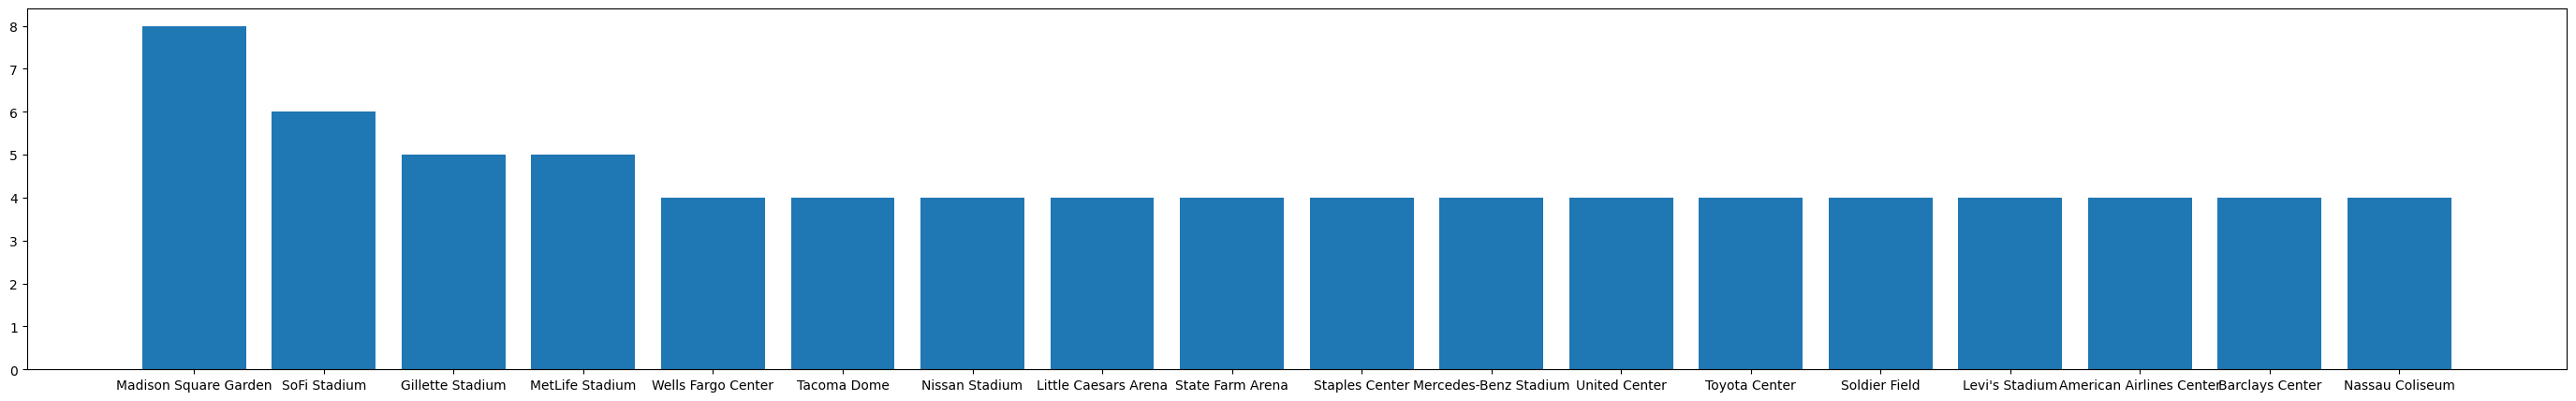

In [240]:
fig1, ax1 = plt.subplots(figsize = (35,5))
ax1.bar(venue_counts_df['Venue'], venue_counts_df['count'])

plt.show()

I think continuing my analysis I will look at the population of each city as well as the arts spending. Of the top five, I was not shocked to see MSG, SoFi, and MetLife (NYC (and New Jersey) and LA) but I was a little shocked to see Gillette stadium - if I was planning a major stadium tour, I would just assume NYC is close enough for people in Boston to take a bus.

Once again, for my final project I plan on adding states to each stadium. I will work on that, I just didn't have time for this checkpoint since I have to travel home for Thanksgiving. It would be really cool if I had time to implement a kind of heat map of the cities in my final project, to see where even within the states they are, but the current vision is a chart that graphs the income of a state alongside the # of times a state has been visited.